### Plot the time series for 365-day rolling reliability metrics (SAIDI, SAIFI, and CAIDI)

In [22]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import platform

In [24]:
# Environment/Package version logging for reproducibility.
# This cell logs the current environment and Python package versions for transparency and reproducibility.
print(f"Python Version: {platform.python_version()}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Numpy Version: {np.__version__}")

Python Version: 3.12.4
Pandas Version: 2.2.2
Matplotlib Version: 3.8.4
Numpy Version: 1.26.4


In [26]:
# Get the base directory (current working directory)
base_dir = os.getcwd()

In [28]:
# Set relative paths
eaglei_reliability_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "Output", "eaglei_rolling_reliability.csv"))
IEEE_reliability_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "Output", "IEEE_rolling_reliability.csv"))
IEEE_reliability_MED_excluded_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "Output", "IEEE_rolling_reliability_MED_excluded.csv"))
IEEE_customer_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "IEEE", "customer counts.csv"))

In [30]:
# Read in all the required input data
eaglei = pd.read_csv(eaglei_reliability_path)
IEEE = pd.read_csv(IEEE_reliability_path)
IEEE_NO_MED = pd.read_csv(IEEE_reliability_MED_excluded_path)

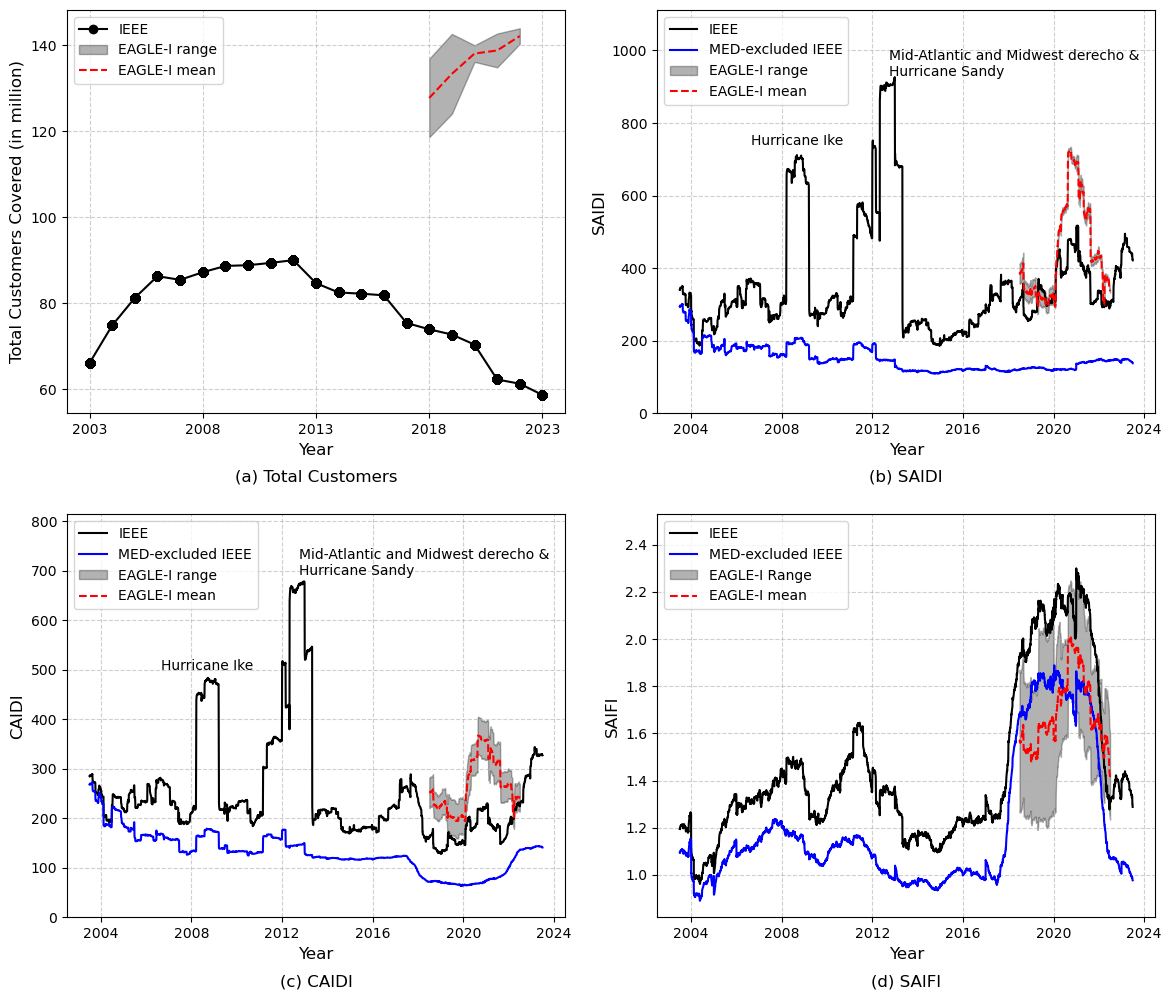

In [32]:
def plot_four_subplots(ieee_df, ieee_no_med_df, eaglei_df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of subplots
    
    # (a) Total Customers
    axes[0, 0].plot(
        ieee_df['Year'],
        ieee_df['total_customers'] / 1_000_000,
        marker='o',
        linestyle='-',
        color='black',
        label='IEEE',
    )
    axes[0, 0].fill_between(
        eaglei_df['year'],
        eaglei_df['total_min'] / 1_000_000,
        eaglei_df['total_max'] / 1_000_000,
        color='black',
        alpha=0.3,
        label='EAGLE-I range',
    )
    total_mean = (eaglei_df['total_min'] + eaglei_df['total_max']) / 2 / 1_000_000
    axes[0, 0].plot(
        eaglei_df['year'],
        total_mean,
        linestyle='--',
        color='red',
        label='EAGLE-I mean',
    )
    axes[0, 0].set_xlabel('Year', fontsize=12)
    axes[0, 0].set_ylabel('Total Customers Covered (in million)', fontsize=12)
    axes[0, 0].set_xticks(range(2003, 2024, 5))
    axes[0, 0].legend(loc="upper left")
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)
    axes[0, 0].text(0.5, -0.17, "(a) Total Customers", transform=axes[0, 0].transAxes, ha="center", fontsize=12)
    
    # (b) SAIDI
    ieee_df['Date'] = pd.to_datetime(ieee_df['Date'])
    ieee_no_med_df['Date'] = pd.to_datetime(ieee_no_med_df['Date'])
    eaglei_df['Date'] = pd.to_datetime(eaglei_df['Date'])
    axes[0, 1].plot(
        ieee_df['Date'],
        ieee_df['SAIDI'],
        linestyle='-',
        color='black',
        label='IEEE',
    )
    axes[0, 1].plot(
        ieee_no_med_df['Date'], 
        ieee_no_med_df['SAIDI'], 
        linestyle='-', 
        color='blue', 
        label='MED-excluded IEEE', 
    )
    axes[0, 1].fill_between(
        eaglei_df['Date'],
        eaglei_df['saidi_min'],
        eaglei_df['saidi_max'],
        color='black',
        alpha=0.3,
        label='EAGLE-I range',
    )
    saidi_mean = (eaglei_df['saidi_min'] + eaglei_df['saidi_max']) / 2
    axes[0, 1].plot(
        eaglei_df['Date'],
        saidi_mean,
        linestyle='--',
        color='red',
        label='EAGLE-I mean',
    )
    # Add text labels for SAIDI IEEE line
    hurricane_ike_date = pd.Timestamp("2008-09-01")  # Approximate date for Hurricane Ike
    derecho_hurricane_sandy_date = pd.Timestamp("2012-10-01")  # Approximate combined date for events in 2012
    
    idx_2008 = ieee_df['Date'] == hurricane_ike_date
    idx_2012 = ieee_df['Date'] == derecho_hurricane_sandy_date
    if idx_2008.any():
        axes[0, 1].annotate(
            'Hurricane Ike',
            xy=(hurricane_ike_date, ieee_df.loc[idx_2008, 'SAIDI'].iloc[0]),
            xytext=(0, 7),  # Place above the point
            textcoords='offset points',
            fontsize=10,
            color='black',
            ha='center'  # Center horizontally
        )
    if idx_2012.any():
        axes[0, 1].annotate(
            'Mid-Atlantic and Midwest derecho &\nHurricane Sandy',
            xy=(derecho_hurricane_sandy_date, ieee_df.loc[idx_2012, 'SAIDI'].iloc[0]),
            xytext=(0, 7),
            textcoords='offset points',
            fontsize=10,
            color='black'
        )
    axes[0, 1].set_xlabel('Year', fontsize=12)
    axes[0, 1].set_ylabel('SAIDI', fontsize=12)
    # Increase y-axis range to accommodate 2012 label
    saidi_max_val = max(ieee_df['SAIDI'].max(), ieee_no_med_df['SAIDI'].max(), eaglei_df['saidi_max'].max())
    axes[0, 1].set_ylim(bottom=0, top=saidi_max_val * 1.2)  # Extend top by 20%
    axes[0, 1].legend(loc="upper left")
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)
    axes[0, 1].text(0.5, -0.17, "(b) SAIDI", transform=axes[0, 1].transAxes, ha="center", fontsize=12)
    
    # (c) CAIDI
    caidi_min = eaglei_df[
        ['caidi_max_method', 'caidi_sum_method', 'caidi_moving_avg_method']
    ].min(axis=1)
    caidi_max = eaglei_df[
        ['caidi_max_method', 'caidi_sum_method', 'caidi_moving_avg_method']
    ].max(axis=1)
    axes[1, 0].plot(
        ieee_df['Date'],
        ieee_df['CAIDI'],
        linestyle='-',
        color='black',
        label='IEEE',
    )
    axes[1, 0].plot(
        ieee_no_med_df['Date'],
        ieee_no_med_df['CAIDI'],
        linestyle='-',
        color='blue',
        label='MED-excluded IEEE',
    )
    axes[1, 0].fill_between(
        eaglei_df['Date'],
        caidi_min,
        caidi_max,
        color='black',
        alpha=0.3,
        label='EAGLE-I range',
    )
    caidi_mean = (caidi_min + caidi_max) / 2
    axes[1, 0].plot(
        eaglei_df['Date'],
        caidi_mean,
        linestyle='--',
        color='red',
        label='EAGLE-I mean',
    )
    # Add text labels for CAIDI IEEE line
    if idx_2008.any():
        axes[1, 0].annotate(
            'Hurricane Ike',
            xy=(hurricane_ike_date, ieee_df.loc[idx_2008, 'CAIDI'].iloc[0]),
            xytext=(0, 7),  # Place above the point
            textcoords='offset points',
            fontsize=10,
            color='black',
            ha='center'  # Center horizontally
        )
    if idx_2012.any():
        axes[1, 0].annotate(
            'Mid-Atlantic and Midwest derecho &\nHurricane Sandy',
            xy=(derecho_hurricane_sandy_date, ieee_df.loc[idx_2012, 'CAIDI'].iloc[0]),
            xytext=(0, 7),
            textcoords='offset points',
            fontsize=10,
            color='black'
        )
    axes[1, 0].set_xlabel('Year', fontsize=12)
    axes[1, 0].set_ylabel('CAIDI', fontsize=12)
    # Increase y-axis range to accommodate 2012 label
    caidi_max_val = max(ieee_df['CAIDI'].max(), ieee_no_med_df['CAIDI'].max(), caidi_max.max())
    axes[1, 0].set_ylim(bottom=0, top=caidi_max_val * 1.2)  # Extend top by 20%
    axes[1, 0].legend(loc="upper left")
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)
    axes[1, 0].text(0.5, -0.17, "(c) CAIDI", transform=axes[1, 0].transAxes, ha="center", fontsize=12)
    
    # (d) SAIFI
    saifi_min = eaglei_df[
        [
            'saifi_max_method_min',
            'saifi_sum_method_min',
            'saifi_moving_avg_min',
            'saifi_max_method_max',
            'saifi_sum_method_max',
            'saifi_moving_avg_max'
        ]
    ].min(axis=1)
    saifi_max = eaglei_df[
        [
            'saifi_max_method_max',
            'saifi_sum_method_max',
            'saifi_moving_avg_max',
            'saifi_max_method_min',
            'saifi_sum_method_min',
            'saifi_moving_avg_min'
        ]
    ].max(axis=1)
    axes[1, 1].plot(
        ieee_df['Date'],
        ieee_df['SAIFI'],
        linestyle='-',
        color='black',
        label='IEEE',
    )
    axes[1, 1].plot(
        ieee_no_med_df['Date'],
        ieee_no_med_df['SAIFI'],
        linestyle='-',
        color='blue',
        label='MED-excluded IEEE',
    )
    axes[1, 1].fill_between(
        eaglei_df['Date'],
        saifi_min,
        saifi_max,
        color='black',
        alpha=0.3,
        label='EAGLE-I Range',
    )
    saifi_mean = (saifi_min + saifi_max) / 2
    axes[1, 1].plot(
        eaglei_df['Date'],
        saifi_mean,
        linestyle='--',
        color='red',
        label='EAGLE-I mean',
    )

    axes[1, 1].set_xlabel('Year', fontsize=12)
    axes[1, 1].set_ylabel('SAIFI', fontsize=12)
    # Increase y-axis range to accommodate 2012 label
    saifi_max_val = max(ieee_df['SAIFI'].max(), ieee_no_med_df['SAIFI'].max(), saifi_max.max())
    axes[1, 1].set_ylim(top=saifi_max_val * 1.1)  # Extend top by 20%
    axes[1, 1].legend(loc="upper left")
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)
    axes[1, 1].text(0.5, -0.17, "(d) SAIFI", transform=axes[1, 1].transAxes, ha="center", fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    # Increase space between rows
    plt.subplots_adjust(hspace=0.25)
    plt.show()

plot_four_subplots(IEEE, IEEE_NO_MED, eaglei)